# Syllabification

## Setup

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')
%cd '/content/drive/My Drive/Deep Comedy/src'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Deep Comedy/src


In [ ]:
import logging
import re
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from masking import create_masks
from transformer import Transformer
from learning_rate_scheduler import CustomSchedule

In [ ]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

## Prepare the dataset

### Download and collect

Download both the regular and the syllabified Divine Comedy text from [[1]](#asperti).

In [ ]:
url = 'https://raw.githubusercontent.com/asperti/Dante/main'

names_nosyll = ['inferno.txt', 'purgatorio.txt', 'paradiso.txt']
names_syll = ['inferno_syllnew.txt', 'purgatorio_syllnew.txt', 'paradiso_syllnew.txt']

paths_nosyll = [tf.keras.utils.get_file(name, origin=f'{url}/{name}') for name in names_nosyll]
paths_syll = [tf.keras.utils.get_file(name, origin=f'{url}/{name}') for name in names_syll]

In [ ]:
def cleanup(verse):
    # remove verse numeration and add start-of-verse ('<') and end-of-verse ('>') tokens
    return f"<{re.sub(r'[0-9]+', '', verse).strip()}>"

> `<` and `>` are the **_begin-of-verse_** and **_end-of-verse_** tokens, respectively.

In [ ]:
def collect_verses(path):
    with open(path) as f:
        # remove blank lines and headers
        return [cleanup(line) for line in f if line != '\n' and '•' not in line]

In [ ]:
verses_nosyll = [verse for path in paths_nosyll for verse in collect_verses(path)]
verses_syll = [verse for path in paths_syll for verse in collect_verses(path)]

In [ ]:
verses_nosyll[:10]

['<Nel mezzo del cammin di nostra vita>',
 '<mi ritrovai per una selva oscura,>',
 '<ché la diritta via era smarrita.>',
 '<Ahi quanto a dir qual era è cosa dura>',
 '<esta selva selvaggia e aspra e forte>',
 '<che nel pensier rinova la paura!>',
 '<Tant’ è amara che poco è più morte;>',
 '<ma per trattar del ben ch’i’ vi trovai,>',
 '<dirò de l’altre cose ch’i’ v’ho scorte.>',
 '<Io non so ben ridir com’ i’ v’intrai,>']

In [ ]:
verses_syll[:10]

['<|Nel |mez|zo |del |cam|min |di |no|stra |vi|ta>',
 '<|mi |ri|tro|vai |per |u|na |sel|va o|scu|ra,>',
 '<|ché |la |di|rit|ta |via |e|ra |smar|ri|ta.>',
 '<|Ahi |quan|to a |dir |qual |e|ra è |co|sa |du|ra>',
 '<|e|sta |sel|va |sel|vag|gia e |a|spra e |for|te>',
 '<|che |nel |pen|sier |ri|no|va |la |pa|u|ra!>',
 '<|Tan|t’ è |a|ma|ra |che |po|co è |più |mor|te;>',
 '<|ma |per |trat|tar |del |ben |ch’ i’ |vi |tro|vai,>',
 '<|di|rò |de |l’ al|tre |co|se |ch’ i’ |v’ ho |scor|te.>',
 '<|Io |non |so |ben |ri|dir |com’ |i’ |v’ in|trai,>']

In [ ]:
assert len(verses_nosyll) == len(verses_syll)

NUM_VERSES = len(verses_nosyll)

### Tokenize

Both the regular and the syllabified Divine Comedy will be tokenized by characters.

In [ ]:
def tokenize(verses):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', lower=False, char_level=True)
  tokenizer.fit_on_texts(verses)

  tensor = tokenizer.texts_to_sequences(verses)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post').astype(np.int64)

  return tensor, tokenizer

In [ ]:
tensor_nosyll, tokenizer_nosyll = tokenize(verses_nosyll)
tensor_syll, tokenizer_syll = tokenize(verses_syll)

In [ ]:
tensor_nosyll[0]

array([13, 52,  2,  8,  1, 16,  2, 27, 27,  5,  1, 12,  2,  8,  1, 11,  3,
       16, 16,  4,  6,  1, 12,  4,  1,  6,  5, 10,  9,  7,  3,  1, 19,  4,
        9,  3, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0])

In [ ]:
tokenizer_nosyll.sequences_to_texts([tensor_nosyll[0]])

['< N e l   m e z z o   d e l   c a m m i n   d i   n o s t r a   v i t a >']

> As you can see from the cell above, for some reason, `sequences_to_texts` puts a space between characters (when `char_level=True` in the `Tokenizer` instance). The following function takes care of this issue:

In [ ]:
def sequences_to_text(tokenizer, sequences):
    return [s.replace('  ', '*').replace(' ', '').replace('*', ' ') for s in tokenizer.sequences_to_texts(sequences)]

In [ ]:
verse = sequences_to_text(tokenizer_nosyll, [tensor_nosyll[0]])
verse

['<Nel mezzo del cammin di nostra vita>']

In [ ]:
tensor_syll[0]

array([14,  1, 53,  3,  9,  2,  1, 17,  3, 28,  1, 28,  6,  2,  1, 13,  3,
        9,  2,  1, 12,  4, 17,  1, 17,  5,  7,  2,  1, 13,  5,  2,  1,  7,
        6,  1, 11, 10,  8,  4,  2,  1, 20,  5,  1, 10,  4, 15,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [ ]:
sequences_to_text(tokenizer_syll, [tensor_syll[0]])

['<|Nel |mez|zo |del |cam|min |di |no|stra |vi|ta>']

In [ ]:
NOSYLL_SEQ_SIZE = len(tensor_nosyll[0])  # length of a sequence encoding a non-syllabified verse
NOSYLL_VOCAB_SIZE = len(tokenizer_nosyll.word_index)  # number of tokens in the non-syllabified vocaboulary
SYLL_SEQ_SIZE = len(tensor_syll[0])  # length of a sequence encoding a syllabified verse
SYLL_VOCAB_SIZE = len(tokenizer_syll.word_index)  # number of tokens in the syllabified vocaboulary

### Create the dataset

In [ ]:
# Shuffle
indices = np.arange(NUM_VERSES)
np.random.shuffle(indices)
shuffled_nosyll = tensor_nosyll[indices]
shuffled_syll = tensor_syll[indices]

In [ ]:
# ---Split---
# Train: 70
# Validation: 20
# Test: 10

# Compute separation points
end_train = int(0.7 * NUM_VERSES)
end_validation = int(0.9 * NUM_VERSES)

# Train, Validation and Test split
tensor_nosyll_train = shuffled_nosyll[: end_train]
tensor_syll_train = shuffled_syll[: end_train]
tensor_nosyll_val = shuffled_nosyll[end_train : end_validation]
tensor_syll_val = shuffled_syll[end_train : end_validation]
tensor_nosyll_test = shuffled_nosyll[end_validation :]
tensor_syll_test = shuffled_syll[end_validation :]

# Check
print(len(tensor_nosyll_train))
print(len(tensor_syll_train))
print(len(tensor_nosyll_val))
print(len(tensor_syll_val))
print(len(tensor_nosyll_test))
print(len(tensor_syll_test))

9963
9963
2846
2846
1424
1424


In [ ]:
BATCH_SIZE = 64

def prepare_dataset(tensor_input, tensor_output, batch_size=BATCH_SIZE):
  dataset = tf.data.Dataset.from_tensor_slices((tensor_input, tensor_output))
  dataset = dataset.batch(batch_size, drop_remainder=True)
  return dataset

train_dataset = prepare_dataset(tensor_nosyll_train, tensor_syll_train)
val_dataset = prepare_dataset(tensor_nosyll_val, tensor_syll_val)
test_dataset = prepare_dataset(tensor_nosyll_test, tensor_syll_test)

## Define the model

### Set the hyperparameters


In [ ]:
NUM_LAYERS = 2
D_MODEL = 128
DFF = 256
NUM_HEADS = 2
DROPOUT_RATE = 0.1

> The values used in the base model of the original transformer [[2]](#attention) are 
```
NUM_LAYERS=6
D_MODEL=512
DFF=2048
NUM_HEADS=8
DROPOUT_RATE=0.1
```

In [ ]:
syllabifier = Transformer(
    num_layers=NUM_LAYERS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    input_vocab_size=NOSYLL_VOCAB_SIZE+1,
    target_vocab_size=SYLL_VOCAB_SIZE+1,
    pe_input=1000,
    pe_target=1000,
    rate=DROPOUT_RATE)

In [ ]:
# execute a dummy tranformer call
# only for the purpose of initializing the weights

dummy_input = tf.random.uniform((BATCH_SIZE, NOSYLL_SEQ_SIZE), 
                               dtype=tf.int64, 
                               minval=0, 
                               maxval=NOSYLL_VOCAB_SIZE+1)
dummy_target = tf.random.uniform((BATCH_SIZE, SYLL_SEQ_SIZE), 
                                dtype=tf.int64, 
                                minval=0, 
                                maxval=SYLL_VOCAB_SIZE+1)

_,_ = syllabifier(dummy_input, dummy_target,
                  training=False,
                  enc_padding_mask=None,
                  look_ahead_mask=None,
                  dec_padding_mask=None)

In [ ]:
# save the initial random weights to reset the transformer state later on
random_weights = syllabifier.get_weights()

### Choose the optimizer


In [ ]:
optimizer = tf.keras.optimizers.Adam(CustomSchedule(D_MODEL), 
                                     beta_1=0.9, beta_2=0.98, epsilon=1e-9)

### Choose the metrics


In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

> Since the target sequences are padded, it is important to apply a padding mask when calculating loss and accuracy.

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

validation_loss = tf.keras.metrics.Mean(name='validation_loss')
validation_accuracy = tf.keras.metrics.Mean(name='validation_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.Mean(name='test_accuracy')

## Train and validate

In the following, the target (i.e. the syllabified verse) is divided into `tar_inp` and `tar_real`: 
* `tar_inp` is passed as an input to the decoder.
* `tar_real` is that same input shifted by 1: at each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, if `verse` = '<|Nel |mez|zo |del |cam|min |di |no|stra |vi|ta>':
* `tar_inp` =  '<|Nel |mez|zo |del |cam|min |di |no|stra |vi|ta'
* `tar_real` = '|Nel |mez|zo |del |cam|min |di |no|stra |vi|ta>'

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training we use **_teacher-forcing_**, i.e. passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each token, self-attention allows it to look at the previous tokens in the input sequence to better predict the next token.

To prevent the model from peeking at the expected output, the model uses a look-ahead mask.

In [ ]:
EPOCHS = 120

In [ ]:
train_step_signature = [
    tf.TensorSpec(shape=(BATCH_SIZE, NOSYLL_SEQ_SIZE), dtype=tf.int64),
    tf.TensorSpec(shape=(BATCH_SIZE, SYLL_SEQ_SIZE), dtype=tf.int64)
]

In [ ]:
@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = syllabifier(inp, tar_inp,
                                 True,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, syllabifier.trainable_variables)
  optimizer.apply_gradients(zip(gradients, syllabifier.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
@tf.function(input_signature=train_step_signature)
def validation_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  predictions, _ = syllabifier(inp, tar_inp,
                               True,
                               enc_padding_mask,
                               combined_mask,
                               dec_padding_mask)
  loss = loss_function(tar_real, predictions)

  validation_loss(loss)
  validation_accuracy(accuracy_function(tar_real, predictions))

> As you can see from the cell above, the `training` argument of the transformer `call` method is set to `True` in the `validation_step` function. This is done in order to take into account the **regularization loss** (caused by the `Dropout` layers of the transformer) when computing the validation loss. With `training=False`, although it might intuitively look like the right choice for validation/testing, the validation loss (resp. accuracy) would end up being much lower (resp. higher) than the training loss (resp. accuracy). [[3]](#tweet)

In [ ]:
@tf.function(input_signature=train_step_signature)
def test_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  predictions, _ = syllabifier(inp, tar_inp,
                               False,
                               enc_padding_mask,
                               combined_mask,
                               dec_padding_mask)
  loss = loss_function(tar_real, predictions)

  test_loss(loss)
  test_accuracy(accuracy_function(tar_real, predictions))

### Check validation metrics during training

In [ ]:
acc_list = []
loss_list = []
val_acc_list = []
val_loss_list = []

for epoch in range(EPOCHS):
  start = time.time()

  # Train
  train_loss.reset_states()
  train_accuracy.reset_states()

  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  # Validation
  validation_loss.reset_states()
  validation_accuracy.reset_states()    
  
  for (batch, (inp, tar)) in enumerate(val_dataset):
    validation_step(inp, tar)

  print(f'\n\t---Results Epoch {epoch + 1}---')
  print(f'Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
  print(f'Val_Loss {validation_loss.result():.4f} Val_Accuracy {validation_accuracy.result():.4f}')
    
  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

  acc_list.append(train_accuracy.result())
  loss_list.append(train_loss.result())
  val_acc_list.append(validation_accuracy.result())
  val_loss_list.append(validation_loss.result())

Epoch 1 Batch 0 Loss 5.7833 Accuracy 0.0023
Epoch 1 Batch 50 Loss 5.2781 Accuracy 0.0036
Epoch 1 Batch 100 Loss 4.4804 Accuracy 0.0957
Epoch 1 Batch 150 Loss 4.0242 Accuracy 0.1402

	---Results Epoch 1---
Loss 3.9971 Accuracy 0.1426
Val_Loss 2.9591 Val_Accuracy 0.2396
Time taken for 1 epoch: 8.35 secs

Epoch 2 Batch 0 Loss 2.9993 Accuracy 0.2358
Epoch 2 Batch 50 Loss 2.8243 Accuracy 0.2574
Epoch 2 Batch 100 Loss 2.6597 Accuracy 0.2879
Epoch 2 Batch 150 Loss 2.5191 Accuracy 0.3122

	---Results Epoch 2---
Loss 2.5095 Accuracy 0.3138
Val_Loss 2.1285 Val_Accuracy 0.3774
Time taken for 1 epoch: 3.09 secs

Epoch 3 Batch 0 Loss 2.1730 Accuracy 0.3818
Epoch 3 Batch 50 Loss 2.0698 Accuracy 0.3880
Epoch 3 Batch 100 Loss 2.0135 Accuracy 0.3980
Epoch 3 Batch 150 Loss 1.9534 Accuracy 0.4126

	---Results Epoch 3---
Loss 1.9480 Accuracy 0.4142
Val_Loss 1.7183 Val_Accuracy 0.4779
Time taken for 1 epoch: 3.11 secs

Epoch 4 Batch 0 Loss 1.7596 Accuracy 0.4743
Epoch 4 Batch 50 Loss 1.5321 Accuracy 0.5416

In [ ]:
%cd '/content/drive/My Drive/Deep Comedy/img'

/content/drive/My Drive/Deep Comedy/img


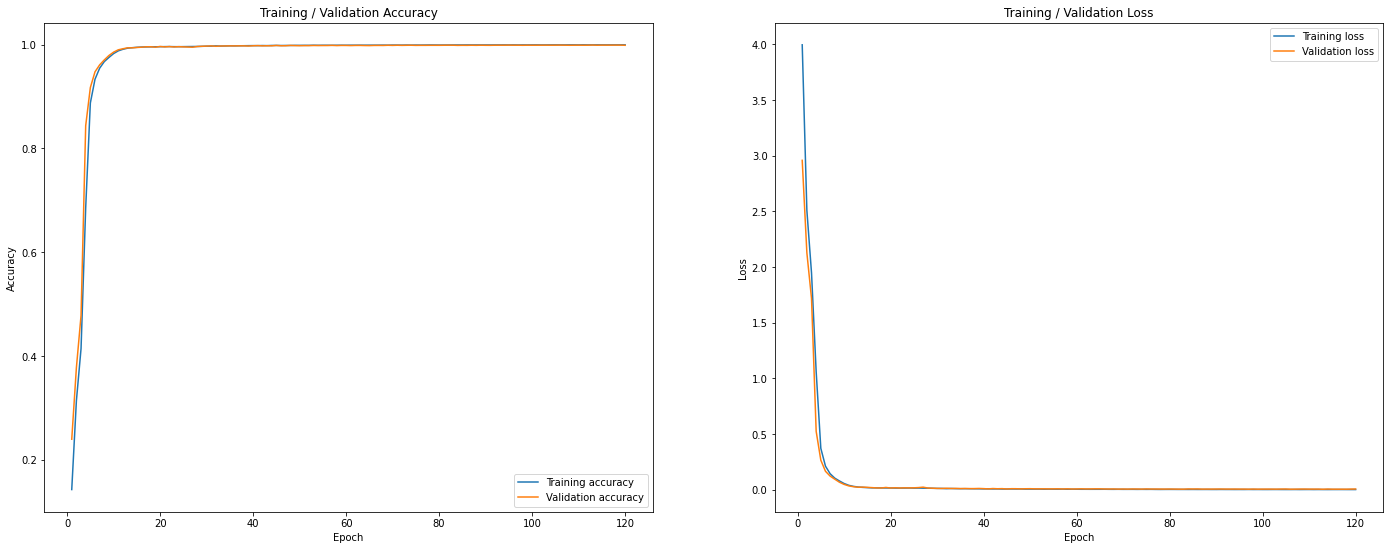

In [ ]:
plt.rcParams['figure.figsize'] = [24, 9]

epochs = list(range(1, EPOCHS+1))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.title('Training / Validation Accuracy')

plt.plot(epochs, acc_list, label='Training accuracy')
plt.plot(epochs, val_acc_list, label='Validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.title('Training / Validation Loss')

plt.plot(epochs, loss_list, label='Training loss')
plt.plot(epochs, val_loss_list, label='Validation loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()

plt.savefig('train_val.png')
plt.show()

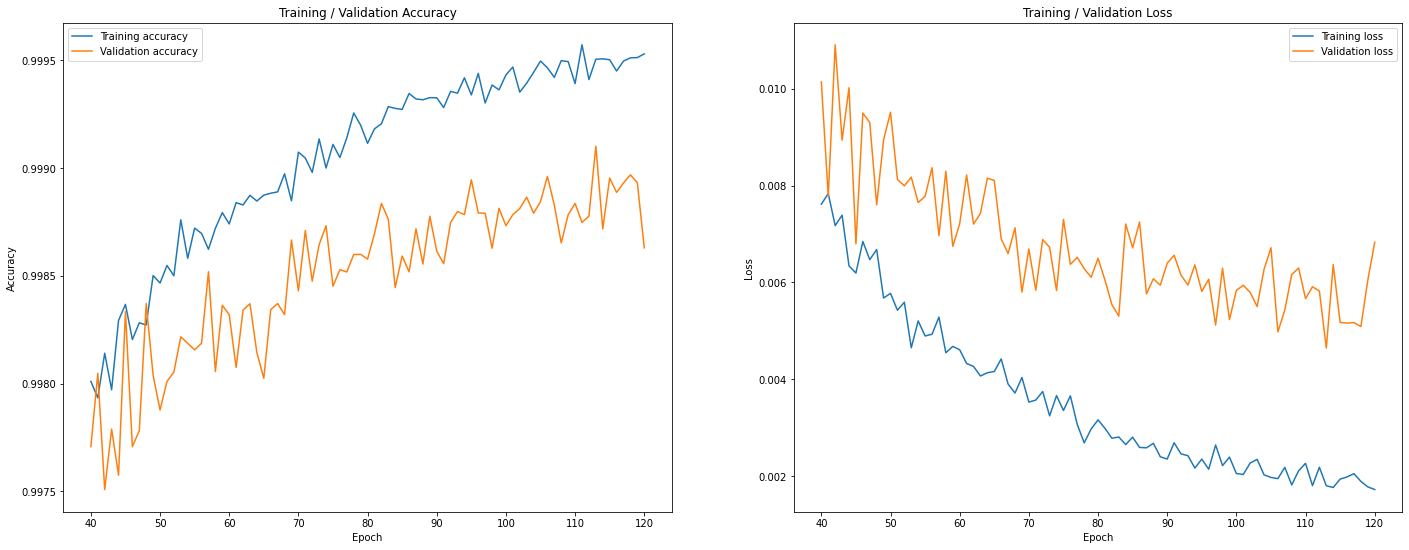

In [ ]:
k = EPOCHS//3

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.title('Training / Validation Accuracy')

plt.plot(epochs[k-1:], acc_list[k-1:], label='Training accuracy')
plt.plot(epochs[k-1:], val_acc_list[k-1:], label='Validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.title('Training / Validation Loss')

plt.plot(epochs[k-1:], loss_list[k-1:], label='Training loss')
plt.plot(epochs[k-1:], val_loss_list[k-1:], label='Validation loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()

plt.savefig('train_val_zoomed.png')
plt.show()

### Considerations about the training
The asymptotic behaviour of the train loss is explained by the fact that the function reaches values close to zero, where progress happens much slower. The smallest values the train loss is able to reach are in the range 0.0005 - 0.0010, where progress stops. Because of this good result, we can assert that the model does not require a bigger size. The range of values 0.0005 - 0.0010 is reached in around 200 epochs, after that the optimizer cannot produce any more improvements; however the progress is already almost insignificant from 150 (roughly), where values are around to 0.0015.

What we need to look at, in order to decide where to stop the training, is the validation loss. From epoch 120 onwards (roughly) the validation loss remains in the range 0.0070 - 0.0080 and does not get smaller, so training further is pointless. We can assert that the model does not reach a condition of overfitting because the value of the validation loss does not increase (aside from the minor effects due to the stochasticity of the training).
A good point to stop the training seems to be 120 epochs, although it has to be noted that improvents after epoch 60 (roughly) are nothing major: doubling the epochs from epoch 60 gives the validation loss a decrease from 0.0100 to 0.0060, so the reward for such a longer training is very little. Having limited computational resources, one could opt for just 60 epochs and get analogous results.

In conclusion, training should be between 60 and 120 epochs.

### Train on the whole (training + validation) dataset

In [ ]:
NEW_EPOCHS = 60

# reset tranformer state
syllabifier.set_weights(random_weights) 

# combine training and validation sets
combined_dataset = train_dataset.concatenate(val_dataset).shuffle(buffer_size=NUM_VERSES)

In [ ]:
for epoch in range(NEW_EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  for (batch, (inp, tar)) in enumerate(combined_dataset):
    train_step(inp, tar)  # now train_step uses the transformer with reset weights

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'\n\t---Results Epoch {epoch + 1}---')
  print(f'Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    
  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 5.8115 Accuracy 0.0019
Epoch 1 Batch 50 Loss 2.8730 Accuracy 0.2530
Epoch 1 Batch 100 Loss 2.4622 Accuracy 0.3113
Epoch 1 Batch 150 Loss 2.2668 Accuracy 0.3437

	---Results Epoch 1---
Loss 2.1343 Accuracy 0.3706
Time taken for 1 epoch: 3.70 secs

Epoch 2 Batch 0 Loss 1.5848 Accuracy 0.4985
Epoch 2 Batch 50 Loss 1.1213 Accuracy 0.6578
Epoch 2 Batch 100 Loss 0.7736 Accuracy 0.7645
Epoch 2 Batch 150 Loss 0.6065 Accuracy 0.8148

	---Results Epoch 2---
Loss 0.5117 Accuracy 0.8431
Time taken for 1 epoch: 3.67 secs

Epoch 3 Batch 0 Loss 0.1940 Accuracy 0.9379
Epoch 3 Batch 50 Loss 0.1620 Accuracy 0.9484
Epoch 3 Batch 100 Loss 0.1477 Accuracy 0.9531
Epoch 3 Batch 150 Loss 0.1375 Accuracy 0.9563

	---Results Epoch 3---
Loss 0.1278 Accuracy 0.9597
Time taken for 1 epoch: 3.68 secs

Epoch 4 Batch 0 Loss 0.0730 Accuracy 0.9755
Epoch 4 Batch 50 Loss 0.0731 Accuracy 0.9770
Epoch 4 Batch 100 Loss 0.0684 Accuracy 0.9789
Epoch 4 Batch 150 Loss 0.0624 Accuracy 0.9809

	---Results Ep

In [ ]:
%cd '/content/drive/My Drive/Deep Comedy'

/content/drive/My Drive/Deep Comedy


In [ ]:
#syllabifier.save_weights('syllabification_weights/')

### Quick evaluation

In [ ]:
syllabifier.load_weights('syllabification_weights/')

In [ ]:
for inp, tar in test_dataset:
    test_step(inp, tar)

print(f'Test_Loss {test_loss.result():.4f} Test_Accuracy {test_accuracy.result():.4f}')

Test_Loss 0.0055 Test_Accuracy 0.9991


## Syllabify

The syllabification process unfolds through the following steps:

1. A non-syllabified verse is given as input to the encoder.
2. The decoder input is initialized to the start-of-verse token (`<`).
3. Calculate the padding masks and the look ahead masks.
4. The model makes predictions of the next character for each character in the output. Most of these are redundant: use the predictions from the last character.
5. if the predicted character is the end-of-verse token (`>`), stop; otherwise, concatenate the predicted character to the decoder input and pass it to the decoder itself, then go back to step 3.


In [ ]:
def syllabify(verse):
  encoder_input = tokenizer_nosyll.texts_to_sequences([verse])
  encoder_input = tf.convert_to_tensor(encoder_input)

  start = tf.constant(tokenizer_syll.word_index['<'], dtype=tf.int64)
  end = tf.constant(tokenizer_syll.word_index['>'], dtype=tf.int64)

  decoder_input = tf.convert_to_tensor([start], dtype=tf.int64)
  decoder_input = tf.expand_dims(decoder_input, axis=0)

  predicted_id = 0
  while predicted_id != end:  # return the result if the predicted_id is equal to the end-of-verse token
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, decoder_input)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = syllabifier(encoder_input,
                                                 decoder_input,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # select the last character from the seq_len dimension
    predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.argmax(predictions, axis=-1)

    # concatenate the predicted_id to the output which is given to the decoder as its input
    decoder_input = tf.concat([decoder_input, predicted_id], axis=-1)

  # output.shape (1, tokens)
  syllabified_verse = sequences_to_text(tokenizer_syll, decoder_input.numpy())

  return syllabified_verse, attention_weights

### Display syllabified verses

In [ ]:
def print_syllabification(input, syllabified, ground_truth=None):
  print(f'{"Syllabifier input:":25s} {input}'.replace("<", "").rstrip(">"))
  print(f'{"Syllabifier output:":25s} {syllabified}'.replace("['<", "").rstrip(">']"))
  if ground_truth:
    print(f'{"Correct syllabification:":25s} {ground_truth}'.replace("<", "").rstrip(">"))

In [ ]:
verses = sequences_to_text(tokenizer_nosyll, tensor_nosyll_test[:20])
ground_truths = sequences_to_text(tokenizer_syll, tensor_syll_test[:20])

syllabified_verses = []
attention_weights = []

for verse, ground_truth in zip(verses, ground_truths):
    syllabified_verse, weights = syllabify(verse)
    
    syllabified_verses.append(syllabified_verse)
    attention_weights.append(weights)
    
    print_syllabification(verse, syllabified_verse, ground_truth)
    print()

Syllabifier input:        già per urlare avrian le bocche aperte;
Syllabifier output:       |già |per |ur|la|re av|rian |le |boc|che a|per|te;
Correct syllabification:  |già |per |ur|la|re a|vrian |le |boc|che a|per|te;

Syllabifier input:        Io vidi più folgór vivi e vincenti
Syllabifier output:       |Io |vi|di |più |fol|gór |vi|vi e |vin|cen|ti
Correct syllabification:  |Io |vi|di |più |fol|gór |vi|vi e |vin|cen|ti

Syllabifier input:        che l’anima sicuri di letigio».
Syllabifier output:       |che |l’ a|ni|ma |si|cu|ri |di |le|ti|gio».
Correct syllabification:  |che |l’ a|ni|ma |si|cu|ri |di |le|ti|gio».

Syllabifier input:        Pensa, lettor, s’io mi maravigliava,
Syllabifier output:       |Pen|sa, |let|tor, |s’ io |mi |ma|ra|vi|glia|va,
Correct syllabification:  |Pen|sa, |let|tor, |s’ io |mi |ma|ra|vi|glia|va,

Syllabifier input:        dietro pensando a ciò che si preliba,
Syllabifier output:       |die|tro |pen|san|do a |ciò |che |si |pre|li|ba,
Correct syllabificati

Test with Orlando Furioso:

In [ ]:
furious_orlando = ['<Le donne, i cavallier, l’arme, gli amori,>', 
                   '<le cortesie, l’audaci imprese io canto,>', 
                   '<che furo al tempo che passaro i Mori>', 
                   '<d’Africa il mare, e in Francia nocquer tanto,>', 
                   '<seguendo l’ire e i giovenil furori>', 
                   '<d’Agramante lor re, che si diè vanto>', 
                   '<di vendicar la morte di Troiano>', 
                   '<sopra re Carlo imperator romano.>']

for verse in furious_orlando:
    syllabified_verse, _ = syllabify(verse)
    print_syllabification(verse, syllabified_verse)
    print()

Syllabifier input:        Le donne, i cavallier, l’arme, gli amori,
Syllabifier output:       |Le |don|ne, i |ca|val|lier, |l’ ar|me, |gli a|mo|ri,

Syllabifier input:        le cortesie, l’audaci imprese io canto,
Syllabifier output:       |le |cor|te|sie, |l’ au|da|ci im|pre|se io |can|to,

Syllabifier input:        che furo al tempo che passaro i Mori
Syllabifier output:       |che |fu|ro al |tem|po |che |pas|sa|ro i |Mo|ri

Syllabifier input:        d’Africa il mare, e in Francia nocquer tanto,
Syllabifier output:       |d’ A|fri|ca il |ma|re, e |in |Fran|cia |noc|quer |tan|to,

Syllabifier input:        seguendo l’ire e i giovenil furori
Syllabifier output:       |se|guen|do |l’ i|re e i |gio|ve|nil |fu|ro|ri

Syllabifier input:        d’Agramante lor re, che si diè vanto
Syllabifier output:       |d’ A|gra|man|te |lor |re, |che |si |diè |van|to

Syllabifier input:        di vendicar la morte di Troiano
Syllabifier output:       |di |ven|di|car |la |mor|te |di |Tro|ia|no

Syllabif

### Attention plots

The `syllabify` function also returns a dictionary of attention maps that can be used to visualize the inner workings of the model.

In [ ]:
verse, ground_truth, syllabified_verse, weights = list(zip(
    verses, ground_truths, syllabified_verses, attention_weights))[0]

print_syllabification(verse, syllabified_verse, ground_truth)

Syllabifier input:        già per urlare avrian le bocche aperte;
Syllabifier output:       |già |per |ur|la|re av|rian |le |boc|che a|per|te;
Correct syllabification:  |già |per |ur|la|re a|vrian |le |boc|che a|per|te;


In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate '<' in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  ax.set_xticklabels(in_tokens, rotation=90)
  ax.set_yticklabels(translated_tokens)

In [ ]:
in_tokens = [char for char in verse]
translated_tokens = [char for char in syllabified_verse[0]]

In [ ]:
def plot_attention_weights(in_tokens, translated_tokens, attention_heads):
  fig = plt.figure(figsize=(20, 15))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.savefig('attention_plots.png')
  plt.show()

In [ ]:
%cd '/content/drive/My Drive/Deep Comedy/img'

/content/drive/My Drive/Deep Comedy/img


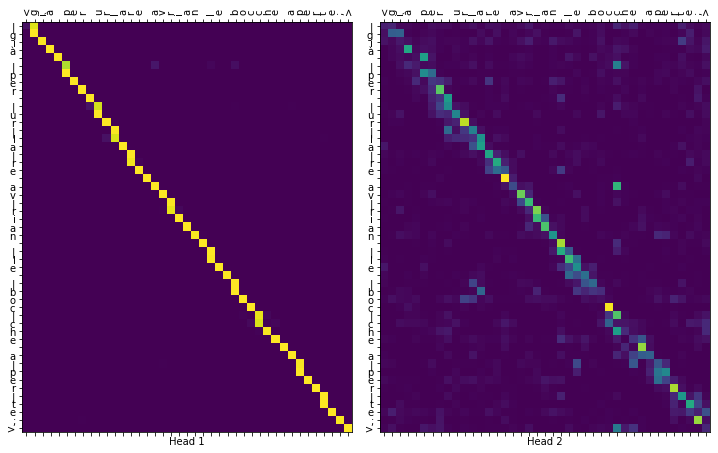

In [ ]:
plot_attention_weights(in_tokens, translated_tokens, weights['decoder_layer1_block2'][0])

## References
<a name="asperti">[1]</a> [`Dante` repository at prof. Asperti's GitHub page](https://github.com/asperti/Dante)
<br>
<a name="attention">[2]</a> [Attention Is All You Need, Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)
<br>
<a name="tweet">[3]</a> [Aurélien Geron's Twitter thread, 27 March 2019](https://twitter.com/aureliengeron/status/1110839223878184960)